Maximum stable dt: 0.0000029752
Using dt: 0.0000029752 with 27626 time steps
CFL ratio: 1.0000 (should be <= 1.0)
Grid setup complete: 501 spatial points, 27627 time points
S range: [90, 110], dS: 0.0400
T range: [0, 0.0822], dt: 0.0000029752

Terminal condition (payoff at expiration):
Min: -5.000000, Max: 0.000000
Sample @ S=100,100,100: 0.000000,0.000000,0.000000

Tridiagonal matrix coefficients at middle grid:
a[250]: 0.371709, b[250]: 1.743790, c[250]: 0.372081

At step 27620, t=0.082174:
Max diff: 4.876506e-03, Put pts: 114.0, Call pts: 127.0
Put boundary: S=95.4400
Call boundary: S=104.6400

At step 24858, t=0.073957:
Max diff: 1.185794e-03, Put pts: 7.0, Call pts: 7.0
Put boundary: S=104.0000
Call boundary: S=95.0400

At step 22096, t=0.065739:
Max diff: 5.112598e-03, Put pts: 5.0, Call pts: 6.0
Put boundary: S=90.0000
Call boundary: S=110.0000

At step 19334, t=0.057522:
Max diff: 7.609600e-03, Put pts: 4.0, Call pts: 5.0
Put boundary: S=90.0000
Call boundary: S=110.0000

At st

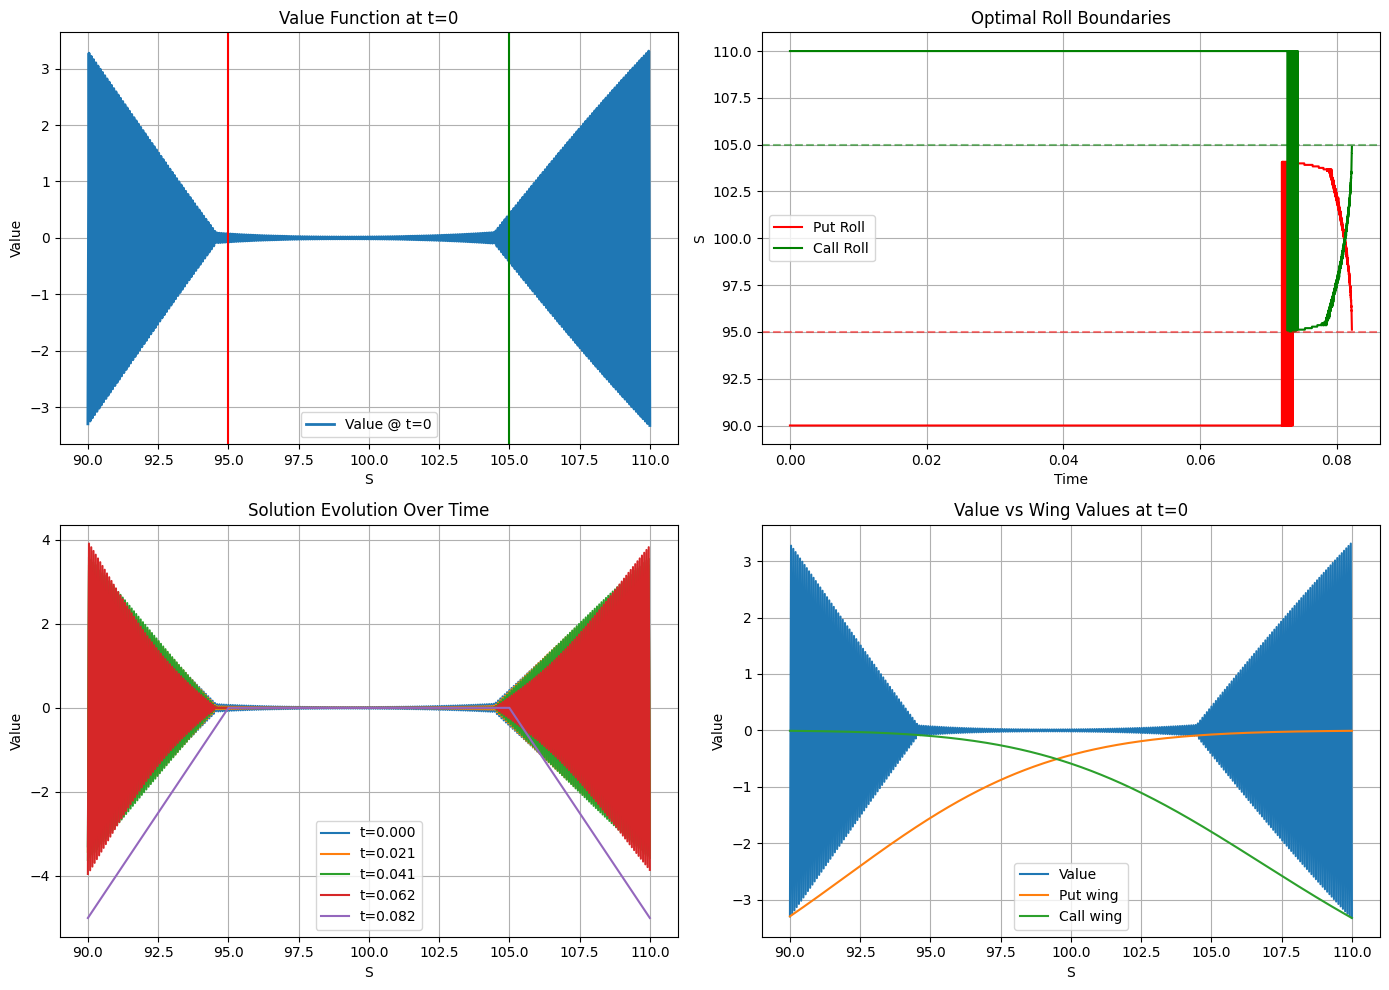

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import solve_banded
import time
import math
from numba import njit, prange

@njit
def _cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

@njit
def bs_call_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(S - K, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma * sigma) * tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma * math.sqrt(tau)
    return S * _cdf(d1) - K * math.exp(-r * tau) * _cdf(d2)

@njit
def bs_put_numba(S, K, r, sigma, tau):
    if tau <= 1e-10:
        return max(K - S, 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma * sigma) * tau) / (sigma * math.sqrt(tau))
    d2 = d1 - sigma * math.sqrt(tau)
    return K * math.exp(-r * tau) * _cdf(-d2) - S * _cdf(-d1)

@njit
def challenged_put_numba(S, t, Kp_long, Kp_short, r, sigma, T):
    tau = T - t
    return -bs_put_numba(S, Kp_short, r, sigma, tau) + bs_put_numba(S, Kp_long, r, sigma, tau)

@njit
def challenged_call_numba(S, t, Kc_short, Kc_long, r, sigma, T):
    tau = T - t
    return -bs_call_numba(S, Kc_short, r, sigma, tau) + bs_call_numba(S, Kc_long, r, sigma, tau)

@njit
def iron_condor_payoff_numba(S, t, Kp_long, Kp_short, Kc_short, Kc_long, r, sigma, T):
    tau = T - t
    return (
        bs_put_numba(S, Kp_long,  r, sigma, tau)
      - bs_put_numba(S, Kp_short, r, sigma, tau)
      - bs_call_numba(S, Kc_short, r, sigma, tau)
      + bs_call_numba(S, Kc_long,  r, sigma, tau)
    )

class IronCondorOptimalRoll:
    def __init__(self, S0, r, sigma, T,
                 K_put_long, K_put_short,
                 K_call_short, K_call_long):
        
        self.S0    = S0
        self.r     = r
        self.sigma = sigma
        self.T     = T
        self.Kp_long, self.Kp_short = K_put_long, K_put_short
        self.Kc_short, self.Kc_long = K_call_short, K_call_long

    def setup_grid(self, S_min, S_max, Ns, Nt):
        self.S_min, self.S_max = S_min, S_max
        self.Ns, self.Nt    = Ns, Nt
        self.dS = (S_max - S_min) / Ns
        
        dt_max = 0.9 * (self.dS**2) / (self.sigma**2 * S_max**2)
        print(f"Maximum stable dt: {dt_max:.10f}")
        self.dt = min(self.T / Nt, dt_max)
        self.Nt = int(self.T / self.dt) + 1
        self.dt = self.T / self.Nt
        print(f"Using dt: {self.dt:.10f} with {self.Nt} time steps")
        print(f"CFL ratio: {self.dt/dt_max:.4f} (should be <= 1.0)")

        
        self.S_grid = np.linspace(S_min, S_max, Ns+1)
        self.t_grid = np.linspace(0.0, self.T, self.Nt+1)

        
        self.J = np.zeros((self.Nt+1, Ns+1))
        self.roll_put  = np.full(self.Nt+1, np.nan)
        self.roll_call = np.full(self.Nt+1, np.nan)
        print(f"Grid setup complete: {Ns+1} spatial points, {self.Nt+1} time points")
        print(f"S range: [{S_min}, {S_max}], dS: {self.dS:.4f}")
        print(f"T range: [0, {self.T:.4f}], dt: {self.dt:.10f}")

    def _solve_tridiagonal(self, a, b, c, d):
        n = len(d)
        ab = np.zeros((3, n))
        ab[0, 1:] = c[:-1]
        ab[1, :]  = b
        ab[2, :-1]= a[1:]
        return solve_banded((1,1), ab, d)

    def build_coeffs(self):
        a = np.zeros(self.Ns+1)
        b = np.zeros(self.Ns+1)
        c = np.zeros(self.Ns+1)
        for i in range(1, self.Ns):
            S = self.S_grid[i]
            alpha = 0.5 * self.sigma**2 * S**2 / self.dS**2
            beta  =     self.r       * S      / (2*self.dS)
            a[i] = self.dt * (alpha - beta)
            b[i] = 1 + self.dt * (2*alpha + self.r)
            c[i] = self.dt * (alpha + beta)
        b[0] = b[self.Ns] = 1.0
        return a, b, c

    def solve(self):
        start_time = time.time()
        
        for i, S in enumerate(self.S_grid):
            self.J[-1, i] = iron_condor_payoff_numba(
                S, self.T,
                self.Kp_long, self.Kp_short,
                self.Kc_short, self.Kc_long,
                self.r, self.sigma, self.T)
        
        print("\nTerminal condition (payoff at expiration):")
        print(f"Min: {np.min(self.J[-1]):.6f}, Max: {np.max(self.J[-1]):.6f}")
        mid = self.Ns//2
        print(f"Sample @ S={self.S_grid[mid-10]:.0f},{self.S_grid[mid]:.0f},{self.S_grid[mid+10]:.0f}: "
              f"{self.J[-1,mid-10]:.6f},{self.J[-1,mid]:.6f},{self.J[-1,mid+10]:.6f}")

        
        a, b, c = self.build_coeffs()
        print("\nTridiagonal matrix coefficients at middle grid:")
        print(f"a[{mid}]: {a[mid]:.6f}, b[{mid}]: {b[mid]:.6f}, c[{mid}]: {c[mid]:.6f}")

        max_diff = np.zeros(self.Nt)
        num_put = np.zeros(self.Nt)
        num_call= np.zeros(self.Nt)

        for n in range(self.Nt-1, -1, -1):
            t = self.t_grid[n]
            d = self.J[n+1].copy()
            
            d[0]      = iron_condor_payoff_numba(self.S_min, t,
                             self.Kp_long, self.Kp_short,
                             self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)
            d[-1]     = iron_condor_payoff_numba(self.S_max, t,
                             self.Kp_long, self.Kp_short,
                             self.Kc_short, self.Kc_long,
                             self.r, self.sigma, self.T)
            
            J_cont = self._solve_tridiagonal(a, b, c, d)
            self.J[n] = J_cont
            
            put_idx=[]; call_idx=[]
            for i, S in enumerate(self.S_grid):
                if S < self.Kp_short*1.1:
                    valp = challenged_put_numba(S, t,
                             self.Kp_long,self.Kp_short,
                             self.r,self.sigma,self.T)
                    if valp > J_cont[i]:
                        self.J[n,i]=valp; put_idx.append(i)
                if S > self.Kc_short*0.9:
                    valc = challenged_call_numba(S, t,
                             self.Kc_short,self.Kc_long,
                             self.r,self.sigma,self.T)
                    if valc > J_cont[i]:
                        self.J[n,i]=valc; call_idx.append(i)
            num_put[n]=len(put_idx); num_call[n]=len(call_idx)
            if put_idx:  self.roll_put[n]  = self.S_grid[min(put_idx)]
            if call_idx: self.roll_call[n] = self.S_grid[max(call_idx)]
            max_diff[n]=np.max(np.abs(self.J[n]-J_cont))
            
            if n % max(1,self.Nt//10)==0:
                print(f"\nAt step {n}, t={t:.6f}:")
                print(f"Max diff: {max_diff[n]:.6e}, Put pts: {num_put[n]}, Call pts: {num_call[n]}")
                if not np.isnan(self.roll_put[n]):  print(f"Put boundary: S={self.roll_put[n]:.4f}")
                if not np.isnan(self.roll_call[n]): print(f"Call boundary: S={self.roll_call[n]:.4f}")

        end_time=time.time()
        print(f"\nSolution completed in {end_time-start_time:.2f} seconds")
        print(f"Maximum value difference: {np.max(max_diff):.6e}")
        
        V0 = np.interp(self.S0, self.S_grid, self.J[0])
        print(f"\nValue @ t=0, S0={self.S0}: {V0:.6f}")
        if not np.isnan(self.roll_put[0]):  print(f"Initial put boundary: S={self.roll_put[0]:.4f}")
        if not np.isnan(self.roll_call[0]): print(f"Initial call boundary: S={self.roll_call[0]:.4f}")

    def plot_results(self):
        fig, axes = plt.subplots(2,2,figsize=(14,10))
        
        ax=axes[0,0]
        ax.plot(self.S_grid,self.J[0],lw=2,label='Value @ t=0')
        ax.axvline(self.Kp_short, color='r',ls='-')
        ax.axvline(self.Kc_short, color='g',ls='-')
        ax.set(title='Value Function at t=0',xlabel='S',ylabel='Value')
        ax.grid(True); ax.legend()
        
        ax=axes[0,1]
        vp=~np.isnan(self.roll_put); vc=~np.isnan(self.roll_call)
        if vp.any(): ax.plot(self.t_grid[vp],self.roll_put[vp],'r-',label='Put Roll')
        if vc.any(): ax.plot(self.t_grid[vc],self.roll_call[vc],'g-',label='Call Roll')
        ax.axhline(self.Kp_short,color='r',ls='--',alpha=0.5)
        ax.axhline(self.Kc_short,color='g',ls='--',alpha=0.5)
        ax.set(title='Optimal Roll Boundaries',xlabel='Time',ylabel='S')
        ax.grid(True); ax.legend()
        
        ax=axes[1,0]
        for idx in [0,self.Nt//4,self.Nt//2,3*self.Nt//4,self.Nt]:
            ax.plot(self.S_grid,self.J[idx],label=f't={self.t_grid[idx]:.3f}')
        ax.set(title='Solution Evolution Over Time',xlabel='S',ylabel='Value')
        ax.grid(True); ax.legend()
        
        ax=axes[1,1]
        putv=np.array([challenged_put_numba(S,0.0,self.Kp_long,self.Kp_short,self.r,self.sigma,self.T) for S in self.S_grid])
        callv=np.array([challenged_call_numba(S,0.0,self.Kc_short,self.Kc_long,self.r,self.sigma,self.T) for S in self.S_grid])
        ax.plot(self.S_grid,self.J[0],label='Value'); ax.plot(self.S_grid,putv,label='Put wing'); ax.plot(self.S_grid,callv,label='Call wing')
        ax.set(title='Value vs Wing Values at t=0',xlabel='S',ylabel='Value')
        ax.grid(True); ax.legend()
        plt.tight_layout(); plt.show()

if __name__ =="__main__":
    
    S0,r,sigma,T=100,0.05,0.2,30/365.0
    Kp_long,Kp_short=90,95; Kc_short,Kc_long=105,110
    solver=IronCondorOptimalRoll(S0,r,sigma,T,Kp_long,Kp_short,Kc_short,Kc_long)
    solver.setup_grid(90,110,500,200)
    solver.solve()
    solver.plot_results()